**Create A VQ-VAE for the CIFAR 10 Dataset**
\\
The main architecture will take the form Encoder -> Vector Quantization -> Decoder.


In [60]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from tqdm import tqdm

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Residual Layers For Image Processing.** We use Resnet blocks because why not. A few different things to try are: use VIT blocks?

In [62]:
class ResidualLayerBlock(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim):
    super().__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_channels=in_dim, out_channels = res_h_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(res_h_dim),
        nn.ReLU(),
        nn.Conv2d(in_channels=res_h_dim, out_channels=h_dim, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(h_dim)
    )

  def forward(self, x):
    out = x + self.block(x)
    return out

In [63]:
class ResidualLayers(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
    super().__init__()
    self.n_res_layers = n_res_layers
    self.layers = nn.ModuleList(
        [ResidualLayerBlock(in_dim, h_dim, res_h_dim)] * n_res_layers
    )

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return F.relu(x)

**The Encoder Class:** encodes the image into a lower resolution

In [64]:
class Encoder(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
    super().__init__()
    kernel = 4
    stride = 2
    #Maybe remove batch norms?
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_dim, h_dim // 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(h_dim // 2),
        nn.ReLU(),
        nn.Conv2d(h_dim // 2, h_dim, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(h_dim),
        nn.ReLU(),
        nn.Conv2d(h_dim, h_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(h_dim),
        ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers)
    ) 

  def forward(self, x):
    return self.conv_block(x)

**The Vector Quantitizer Class:** Recall that loss is defined as:
$$Recon(x, \hat{x}) + ||sg(z_e(x)) - e||_2^2 + \beta ||z_e(x) - e||_2^2$$
Where the first term is our codebook loss to keep our codebook close to our encoder outputs, and the third term is keep our codebook committed to a discrete distribution. Note that we are going to be quantizing over each individual channel pixel, so we we sample a channel from the discrete distribution. If the original image size is say for example $[64, 3, 32, 32]$, we first rearrange it to have each element be a channel pixel, i.e $[64, 32, 32, 3]$, then flatten it to get each individuala channel yielding $[64 * 32 * 32, 3]$. Now we have $64 * 32 * 32$ seperate channel pixels to query from the latent distribution, and map them to its closest latent distribution value. It should be noted that the outputs from the gradient wont have any actual gradients, because of the nearest neighbor sampling. To deal with this, we copy the gradient from the outputs to the inputs. In other words, we do:
$$e := z_e(x) + sg(e - z_e(x))$$
This allows the gradients of $e$ to be copied over to $z_e(x)$ and backprop to our encoder.

In [65]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) 
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach() #allows for copied gradients
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

**The Decoder Class** Uses the sampled discrete distribution and reconstruct the image.

In [66]:
class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

**The VQAE Module**: This is the main module for the VQ-VAE. The model consists of 
$$Encoder \to VectorQuantitization \to Decoder \to \hat{x}$$
Each image will have its own discrete mapping. Let $f_{vq}(x)$ be the discrete mapping from an image $x$ to its discrete mapping. Once the model is trained, we will have good mappings for $x \to f_{vq}(x)$. However, to actually sample from the VQ-VAE, we need to learn patterns from the learned $f_{vq}(x)$. Once we can sample $f_{vq}$ perhaps using PixelCNN, we can send it into the decoder.

In [67]:
class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)

        return embedding_loss, x_hat, perplexity

In [68]:
training_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [69]:
data_variance = np.var(training_data.data / 255.0)
data_variance

0.06328692405746414

**Define our Hyperparameters**

In [79]:
bsz = 64
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 512
beta = .25
lr = 3e-4
epochs = 25

In [80]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size = bsz, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=32,shuffle=True)

In [81]:
model = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers,
              n_embeddings, embedding_dim, 
              beta).to(device)

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)

In [83]:
train_res_recon_error = []
train_res_perplexity = []
for epoch in range(epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    model.train()
    for data, target in tepoch:
      data = data.to(device)
      optimizer.zero_grad()

      vq_loss, data_recon, perplexity = model(data)
      recon_error = F.mse_loss(data_recon, data) / data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()
      tepoch.set_postfix(loss=float(loss.detach().cpu()))
      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())
    
  avg_loss = 0
  model.eval()
  for data, target in validation_loader:
    data = data.to(device)

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error.item() * 32

    avg_loss += loss / len(validation_data)
    
  print(f'Validation Loss: {avg_loss}')


100%|██████████| 782/782 [00:45<00:00, 17.30batch/s, loss=20.2]


Validation Loss: 0.676543229484558


100%|██████████| 782/782 [00:43<00:00, 17.92batch/s, loss=1.69]


Validation Loss: 0.46559157905578596


100%|██████████| 782/782 [00:43<00:00, 17.85batch/s, loss=0.794]


Validation Loss: 0.40714505624771125


100%|██████████| 782/782 [00:43<00:00, 17.82batch/s, loss=0.675]


Validation Loss: 0.32267864789962764


100%|██████████| 782/782 [00:44<00:00, 17.69batch/s, loss=0.525]


Validation Loss: 0.28474047160148647


100%|██████████| 782/782 [00:44<00:00, 17.59batch/s, loss=0.652]


Validation Loss: 0.2569739655017853


100%|██████████| 782/782 [00:44<00:00, 17.52batch/s, loss=0.523]


Validation Loss: 0.21751385893821723


100%|██████████| 782/782 [00:44<00:00, 17.49batch/s, loss=0.469]


Validation Loss: 0.21356177959442138


100%|██████████| 782/782 [00:43<00:00, 17.82batch/s, loss=0.457]


Validation Loss: 0.18431728153228769


100%|██████████| 782/782 [00:44<00:00, 17.75batch/s, loss=0.397]


Validation Loss: 0.15505920510292062


100%|██████████| 782/782 [00:44<00:00, 17.77batch/s, loss=0.338]


Validation Loss: 0.22211889214515698


100%|██████████| 782/782 [00:45<00:00, 17.36batch/s, loss=0.301]


Validation Loss: 0.17703800430297845


100%|██████████| 782/782 [00:44<00:00, 17.55batch/s, loss=0.347]


Validation Loss: 0.16133251290321365


100%|██████████| 782/782 [00:44<00:00, 17.71batch/s, loss=0.321]


Validation Loss: 0.1485536520242691


100%|██████████| 782/782 [00:44<00:00, 17.62batch/s, loss=0.273]


Validation Loss: 0.1374875079631806


In [88]:
torch.save(model.state_dict(), 'VQ-VAE_Model')

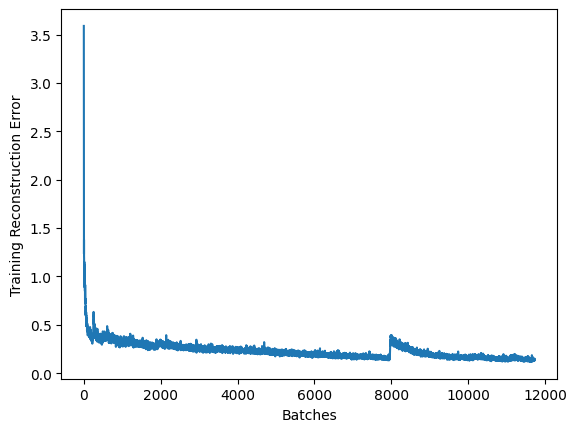

In [84]:
plt.plot(train_res_recon_error)
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()
#plt.xlabel('Batches')
#plt.ylabel('Training Perplexity')
#plt.plot(perplexity)
#plt.show()

In [85]:
model.eval()
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=16,shuffle=True)
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = model(valid_originals)

In [86]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

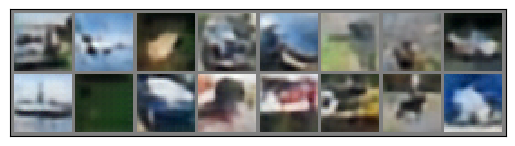

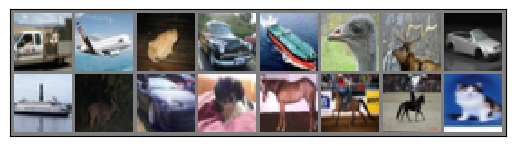

In [87]:
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, )
plt.show()
show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, )
plt.show()

In [ ]:
def sample_model(model):
  #sample 8 x 8 embedding vectors
  encoding_indices = torch.argmin(torch.rand(size = [8 * 8, n_embeddings]), dim=1).to(device).unsqueeze(1)
  encodings = torch.zeros(encoding_indices.shape[0], n_embeddings, device=device)
  encodings.scatter_(1, encoding_indices, 1)
  quantized = torch.matmul(encodings, model.vector_quantization._embedding.weight).view(1, 8, 8, 64)
  quantized = quantized.permute(0, 3, 1, 2).contiguous()
  z_e = model.decoder(quantized)
  return z_e

In [ ]:
plt.imshow(sample_model(model).squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)

In [ ]:
dl = torch.utils.data.DataLoader(training_data,batch_size=1024,shuffle=True)

In [ ]:
out = None
for data, _ in dl:
  data = data.to(device)
  loss, x_hat, perplexity, encodings = model.vector_quantization(model.pre_quantization_conv(model.encoder(data)))
  if out == None:
    out = x_hat
  else:
    out = torch.cat([out, x_hat], dim = 0) 

In [ ]:
x_hat.shape